In [1]:
import json
import re
import copy
from pathlib import Path

# === PATH DI INPUT/OUTPUT ===
data_dir = Path("dataset") / "jump-3" / "train" # <--- Definisce la sottocartella

input_json_path = data_dir / "_annotations.coco.json"
output_json_path = data_dir / "annotations_interpolated.coco.json"

# === FUNZIONI DI SUPPORTO ===

def extract_frame_number(name: str) -> int:
    """
    Estrae il primo gruppo di cifre da una stringa (es. '00063.jpg' -> 63).
    """
    m = re.search(r"(\d+)", name)
    if not m:
        raise ValueError(f"Nessun numero trovato in '{name}'")
    return int(m.group(1))

def build_name_template(example_name: str):
    """
    Dato un nome tipo '00063.jpg' o 'frame_00063.png',
    costruisce una funzione template che dato un numero restituisce
    un nome coerente, es. 64 -> '00064.jpg'.
    """
    m = re.search(r"(\d+)", example_name)
    if not m:
        raise ValueError(f"Nessun numero trovato in '{example_name}'")
    prefix = example_name[:m.start()]
    digits = m.group(1)
    suffix = example_name[m.end():]
    pad = len(digits)

    def make_name(frame_number: int) -> str:
        return f"{prefix}{frame_number:0{pad}d}{suffix}"

    return make_name

def interpolate_list(list_a, list_b, t: float):
    """
    Interpolazione lineare elemento per elemento tra due liste di numeri.
    Restituisce una lista di float.
    """
    if len(list_a) != len(list_b):
        raise ValueError("Liste di lunghezze diverse, impossibile interpolare")
    return [a + t * (b - a) for a, b in zip(list_a, list_b)]

def interpolate_keypoints(kp_a, kp_b, t: float):
    """
    Interpolazione lineare per keypoints COCO (x, y, v) a triplette.
    x e y -> interpolazione lineare e arrotondati a 3 decimali.
    v (visibility) -> tiene quello del frame A se uguale a B,
                      altrimenti interpolazione e round all'intero più vicino.
    """
    if len(kp_a) != len(kp_b):
        raise ValueError("Keypoints di lunghezze diverse, impossibile interpolare")

    new_kp = []
    for i in range(0, len(kp_a), 3):
        xa, ya, va = kp_a[i:i+3]
        xb, yb, vb = kp_b[i:i+3]

        x = xa + t * (xb - xa)
        y = ya + t * (yb - ya)

        # arrotondo a 3 decimali (puoi cambiare se vuoi interi)
        x = round(x, 3)
        y = round(y, 3)

        if va == vb:
            v = va
        else:
            v = int(round(va + t * (vb - va)))

        new_kp.extend([x, y, v])

    return new_kp


# === CARICAMENTO DEL FILE COCO ORIGINALE ===

with open(input_json_path, "r") as f:
    coco = json.load(f)

images = coco["images"]
annotations = coco["annotations"]

# Mappa image_id -> annotation (assume UNA annotation per immagine)
ann_by_image_id = {}
for ann in annotations:
    img_id = ann["image_id"]
    if img_id in ann_by_image_id:
        raise ValueError(f"Più di una annotation per image_id={img_id}, "
                         "il codice assume una sola annotation per immagine.")
    ann_by_image_id[img_id] = ann

# === COSTRUZIONE FRAME INDEX PER OGNI IMMAGINE ===

frames = []  # lista di (frame_number, image_dict)

for img in images:
    # preferisco il nome originale se esiste (campo 'extra'->'name'),
    # altrimenti uso file_name
    if "extra" in img and isinstance(img["extra"], dict) and "name" in img["extra"]:
        name_str = img["extra"]["name"]
    else:
        name_str = img["file_name"]

    frame_number = extract_frame_number(name_str)
    frames.append((frame_number, img))

# ordino per indice di frame
frames.sort(key=lambda x: x[0])

# template per generare nuovi nomi file
# uso il primo esempio che trovo
example_extra_name = None
example_file_name = None

for _, img in frames:
    if "extra" in img and isinstance(img["extra"], dict) and "name" in img["extra"]:
        example_extra_name = img["extra"]["name"]
        break

for _, img in frames:
    if img.get("file_name"):
        example_file_name = img["file_name"]
        break

make_extra_name = build_name_template(example_extra_name) if example_extra_name else None
make_file_name = build_name_template(example_file_name) if example_file_name else None

# === PREPARO ID NUOVI PER IMMAGINI E ANNOTAZIONI ===

max_image_id = max(img["id"] for img in images) if images else 0
max_ann_id = max(ann["id"] for ann in annotations) if annotations else 0

next_image_id = max_image_id + 1
next_ann_id = max_ann_id + 1

new_images = []
new_annotations = []

# === CICLO SULLE COPPIE DI FRAME ESISTENTI PER INTERPOLARE I MANCANTI ===

for (frame_a, img_a), (frame_b, img_b) in zip(frames[:-1], frames[1:]):
    # se non ci sono "buchi" tra frame_a e frame_b, passo oltre
    if frame_b <= frame_a + 1:
        continue

    ann_a = ann_by_image_id[img_a["id"]]
    ann_b = ann_by_image_id[img_b["id"]]

    # per tutti i frame intermedi
    for f in range(frame_a + 1, frame_b):
        t = (f - frame_a) / (frame_b - frame_a)  # 0 < t < 1

        # --- nuova immagine ---
        new_img = copy.deepcopy(img_a)
        new_img["id"] = next_image_id
        next_image_id += 1

        if make_file_name is not None:
            new_img["file_name"] = make_file_name(f)

        if make_extra_name is not None:
            if "extra" not in new_img or not isinstance(new_img["extra"], dict):
                new_img["extra"] = {}
            new_img["extra"]["name"] = make_extra_name(f)

        new_images.append(new_img)

        # --- nuova annotation ---
        new_ann = copy.deepcopy(ann_a)
        new_ann["id"] = next_ann_id
        next_ann_id += 1
        new_ann["image_id"] = new_img["id"]

        # bbox: [x, y, w, h]
        bbox_a = ann_a["bbox"]
        bbox_b = ann_b["bbox"]
        new_bbox = interpolate_list(bbox_a, bbox_b, t)
        new_ann["bbox"] = new_bbox

        # keypoints
        if "keypoints" in ann_a and "keypoints" in ann_b:
            kp_a = ann_a["keypoints"]
            kp_b = ann_b["keypoints"]
            new_kp = interpolate_keypoints(kp_a, kp_b, t)
            new_ann["keypoints"] = new_kp

        new_annotations.append(new_ann)

# === AGGIUNGO LE NUOVE VOCI E SALVO IL NUOVO JSON ===

coco["images"].extend(new_images)
coco["annotations"].extend(new_annotations)

with open(output_json_path, "w") as f:
    json.dump(coco, f, indent=2)

print(f"File salvato in: {output_json_path}")
print(f"Nuove immagini create: {len(new_images)}")
print(f"Nuove annotations create: {len(new_annotations)}")


File salvato in: dataset\jump-3\train\annotations_interpolated.coco.json
Nuove immagini create: 308
Nuove annotations create: 308


In [5]:
import json
import re
import numpy as np
from collections import defaultdict

data_dir = Path("dataset") / "jump-3" / "train" # <--- Definisce la sottocartella

orig_path = data_dir / "_annotations.coco.json"
new_path = data_dir / "annotations_interpolated.coco.json"

# ==========================
#  Funzioni di supporto
# ==========================

def extract_frame_number(name: str) -> int:
    """Estrae il primo gruppo di cifre da una stringa (es. '00063.jpg' -> 63)."""
    m = re.search(r"(\d+)", name)
    if not m:
        raise ValueError(f"Nessun numero trovato in '{name}'")
    return int(m.group(1))

def get_image_name(img):
    """Ritorna il nome 'logico' dell'immagine: extra.name se presente, altrimenti file_name."""
    if "extra" in img and isinstance(img["extra"], dict) and "name" in img["extra"]:
        return img["extra"]["name"]
    return img["file_name"]

def build_frame_index(images, annotations):
    """
    Costruisce:
    - frames_sorted: lista di frame_number ordinati
    - frame_to_img: frame_number -> image dict
    - image_id_to_ann: image_id -> annotation dict
    """
    image_id_to_ann = {}
    for ann in annotations:
        img_id = ann["image_id"]
        if img_id in image_id_to_ann:
            raise ValueError(f"Più di una annotation per image_id={img_id}")
        image_id_to_ann[img_id] = ann

    frame_to_img = {}
    for img in images:
        name = get_image_name(img)
        frame = extract_frame_number(name)
        if frame in frame_to_img:
            raise ValueError(f"Frame {frame} duplicato (due immagini con stesso numero).")
        frame_to_img[frame] = img

        if img["id"] not in image_id_to_ann:
            raise ValueError(f"Nessuna annotazione per image_id={img['id']} (frame {frame})")

    frames_sorted = sorted(frame_to_img.keys())
    return frames_sorted, frame_to_img, image_id_to_ann

def describe_deltas(deltas, desc):
    """Stampa una piccola descrizione statistica delle differenze."""
    deltas = np.array(deltas)
    print(f"\n=== {desc} ===")
    print(f"Numero di step: {len(deltas)}")
    print(f"Min:   {deltas.min():.4f}")
    print(f"Max:   {deltas.max():.4f}")
    print(f"Media: {deltas.mean():.4f}")
    print(f"Mediana: {np.median(deltas):.4f}")

# ==========================
#  Carico JSON originale e nuovo
# ==========================

with open(orig_path, "r") as f:
    coco_orig = json.load(f)

with open(new_path, "r") as f:
    coco_new = json.load(f)

imgs_orig = coco_orig["images"]
anns_orig = coco_orig["annotations"]

imgs_new = coco_new["images"]
anns_new = coco_new["annotations"]

print("=== INFO DI BASE ===")
print(f"Immagini originali:   {len(imgs_orig)}")
print(f"Annotazioni originali:{len(anns_orig)}")
print(f"Immagini nuovo file:  {len(imgs_new)}")
print(f"Annotazioni nuovo file:{len(anns_new)}")

# ==========================
#  Controllo struttura del nuovo file
# ==========================

frames_new, frame_to_img_new, imgid_to_ann_new = build_frame_index(imgs_new, anns_new)

print("\n=== VERIFICA CONTINUITÀ FRAME NEL NUOVO FILE ===")
print(f"Primo frame: {frames_new[0]}")
print(f"Ultimo frame: {frames_new[-1]}")
expected_frames = list(range(frames_new[0], frames_new[-1] + 1))

missing = sorted(set(expected_frames) - set(frames_new))
extra   = sorted(set(frames_new) - set(expected_frames))  # in teoria vuoto

print(f"Numero totale frame attesi: {len(expected_frames)}")
print(f"Numero effettivo frame nel nuovo file: {len(frames_new)}")
print(f"Frame mancanti nel nuovo file: {missing}")
print(f"Frame 'extra' (inattesi): {extra}")

assert len(missing) == 0, "Attenzione: ci sono frame mancanti nel nuovo file!"
print("OK: i frame nel nuovo file sono continui e senza buchi.")

# ==========================
#  Controllo coerenza con file originale
#  (per i frame già esistenti nell'originale)
# ==========================

frames_orig, frame_to_img_orig, imgid_to_ann_orig = build_frame_index(imgs_orig, anns_orig)

print("\n=== CONFRONTO ORIGINALE vs NUOVO SUI FRAME ORIGINALI ===")
mismatches = 0

for frame in frames_orig:
    img_orig = frame_to_img_orig[frame]
    ann_orig = imgid_to_ann_orig[img_orig["id"]]

    # Nel nuovo file cerco la corrispondente immagine con stesso numero frame
    img_new = frame_to_img_new.get(frame, None)
    if img_new is None:
        print(f"ATTENZIONE: frame {frame} era nel file originale ma non nel nuovo!")
        mismatches += 1
        continue

    ann_new = imgid_to_ann_new[img_new["id"]]

    # Confronto bbox
    if ann_orig["bbox"] != ann_new["bbox"]:
        print(f"  Differenza bbox al frame {frame}")
        mismatches += 1

    # Confronto keypoints (se presenti)
    if "keypoints" in ann_orig:
        if ann_orig["keypoints"] != ann_new.get("keypoints", []):
            print(f"  Differenza keypoints al frame {frame}")
            mismatches += 1

if mismatches == 0:
    print("OK: per tutti i frame originali bbox e keypoints coincidono tra file originale e nuovo.")
else:
    print(f"ATTENZIONE: trovate {mismatches} differenze tra originale e nuovo sui frame originali.")

# ==========================
#  Analisi “smoothness” dell’interpolazione
#  (delta tra frame consecutivi)
# ==========================

print("\n=== ANALISI DELLE DIFFERENZE TRA FRAME CONSECUTIVI (NUOVO FILE) ===")

bbox_deltas = []       # norma L2 del delta bbox
kp_deltas = []         # norma L2 del delta keypoints (tutti i punti)
kp_max_point_deltas = []  # massimo delta su un singolo punto

for f1, f2 in zip(frames_new[:-1], frames_new[1:]):
    img1 = frame_to_img_new[f1]
    img2 = frame_to_img_new[f2]
    ann1 = imgid_to_ann_new[img1["id"]]
    ann2 = imgid_to_ann_new[img2["id"]]

    # bbox
    b1 = np.array(ann1["bbox"], dtype=float)
    b2 = np.array(ann2["bbox"], dtype=float)
    bbox_deltas.append(np.linalg.norm(b2 - b1))

    # keypoints (se presenti)
    if "keypoints" in ann1 and "keypoints" in ann2:
        k1 = np.array(ann1["keypoints"], dtype=float)
        k2 = np.array(ann2["keypoints"], dtype=float)
        # delta globale
        kp_deltas.append(np.linalg.norm(k2 - k1))

        # delta per singolo punto (x,y) – ignoro v
        # shape: (num_points, 3)
        k1_pts = k1.reshape(-1, 3)
        k2_pts = k2.reshape(-1, 3)
        deltas_pts = np.linalg.norm(k2_pts[:, :2] - k1_pts[:, :2], axis=1)
        kp_max_point_deltas.append(deltas_pts.max())

# Stampa statistiche
describe_deltas(bbox_deltas, "Delta bbox tra frame consecutivi (norma L2)")
if kp_deltas:
    describe_deltas(kp_deltas, "Delta keypoints globali tra frame consecutivi (norma L2 su tutti i punti)")
    describe_deltas(kp_max_point_deltas, "Massimo delta di singolo keypoint (norma L2 su x,y)")
else:
    print("Nessun keypoints trovato per calcolare i delta.")

print("\nControlla se i delta massimi sono ragionevoli rispetto alla scala dell'immagine/coordinate.")
print("Se vedi valori giganteschi rispetto alla dimensione tipica della bbox o dei keypoints,")
print("potrebbe esserci qualche errore nell'interpolazione.")


=== INFO DI BASE ===
Immagini originali:   78
Annotazioni originali:78
Immagini nuovo file:  386
Annotazioni nuovo file:386

=== VERIFICA CONTINUITÀ FRAME NEL NUOVO FILE ===
Primo frame: 1250
Ultimo frame: 1635
Numero totale frame attesi: 386
Numero effettivo frame nel nuovo file: 386
Frame mancanti nel nuovo file: []
Frame 'extra' (inattesi): []
OK: i frame nel nuovo file sono continui e senza buchi.

=== CONFRONTO ORIGINALE vs NUOVO SUI FRAME ORIGINALI ===
OK: per tutti i frame originali bbox e keypoints coincidono tra file originale e nuovo.

=== ANALISI DELLE DIFFERENZE TRA FRAME CONSECUTIVI (NUOVO FILE) ===

=== Delta bbox tra frame consecutivi (norma L2) ===
Numero di step: 385
Min:   0.0000
Max:   113.1444
Media: 12.8832
Mediana: 7.7906

=== Delta keypoints globali tra frame consecutivi (norma L2 su tutti i punti) ===
Numero di step: 385
Min:   0.0000
Max:   306.7990
Media: 42.3697
Mediana: 28.4877

=== Massimo delta di singolo keypoint (norma L2 su x,y) ===
Numero di step: 385


Mostro 6 immagini (prime 6 per numero di frame).


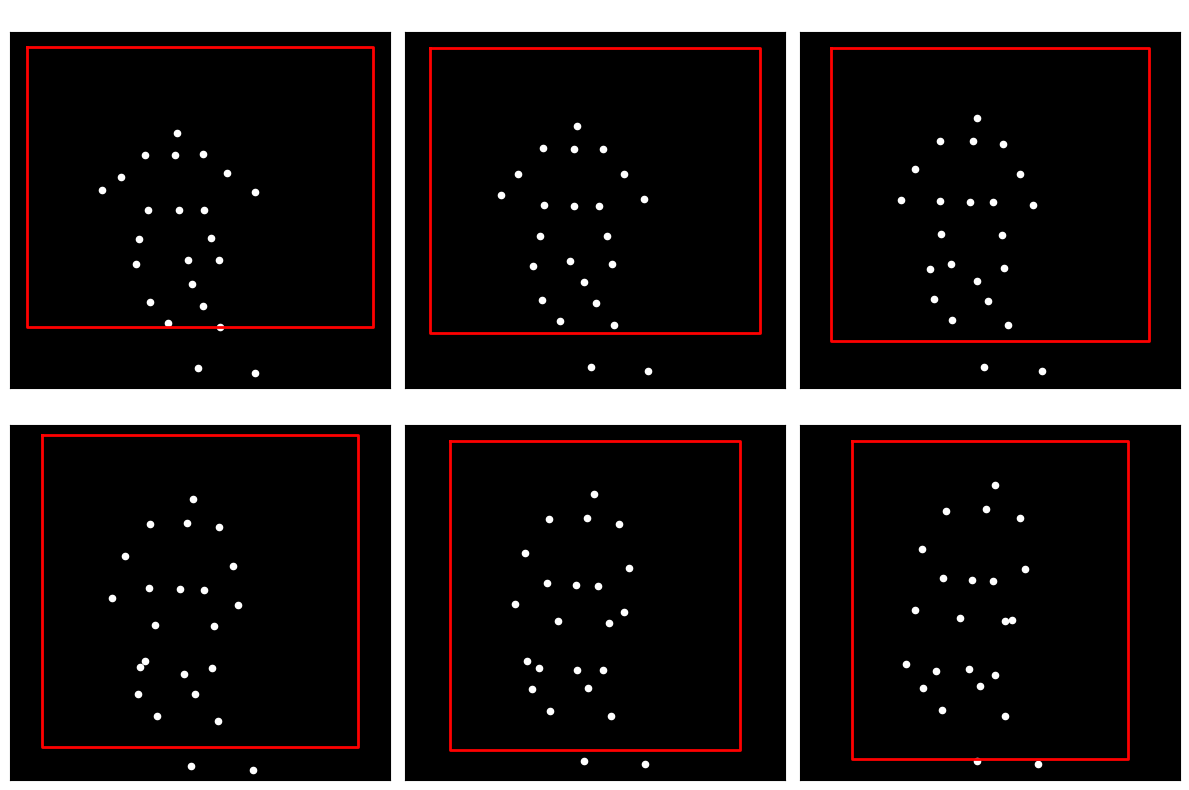

In [9]:
import json
import re
import numpy as np
import matplotlib.pyplot as plt

data_dir = Path("dataset") / "jump-3" / "train" # <--- Definisce la sottocartella

# ====== PATH DEL NUOVO FILE COCO ======
coco_path = data_dir / "annotations_interpolated.coco.json"  # adatta se il nome è diverso

# ====== FUNZIONI DI SUPPORTO ======

def extract_frame_number(name: str) -> int:
    """Estrae il primo gruppo di cifre dal nome (es. '00063.jpg' -> 63)."""
    m = re.search(r"(\d+)", name)
    if not m:
        raise ValueError(f"Nessun numero trovato in '{name}'")
    return int(m.group(1))

def get_image_name(img):
    """Usa extra.name se presente, altrimenti file_name."""
    if "extra" in img and isinstance(img["extra"], dict) and "name" in img["extra"]:
        return img["extra"]["name"]
    return img["file_name"]

# ====== CARICO IL FILE COCO ======
with open(coco_path, "r") as f:
    coco = json.load(f)

images = coco["images"]
annotations = coco["annotations"]

# Mappa image_id -> annotation (assumo una sola annotation per immagine)
ann_by_image = {ann["image_id"]: ann for ann in annotations}

# Costruisco lista (frame_number, image_dict, ann_dict)
frames = []
for img in images:
    frame_num = extract_frame_number(get_image_name(img))
    ann = ann_by_image.get(img["id"], None)
    if ann is None:
        continue
    frames.append((frame_num, img, ann))

# Ordino per frame_number
frames.sort(key=lambda x: x[0])

# Prendo le prime 6 immagini (se ce ne sono almeno 6)
n_show = min(6, len(frames))
frames_to_show = frames[:n_show]

print(f"Mostro {n_show} immagini (prime {n_show} per numero di frame).")

# ====== PLOT 6 VISUALIZZAZIONI ======

fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()  # per indicizzazione semplice

for idx, (frame_num, img, ann) in enumerate(frames_to_show):
    ax = axes[idx]
    ax.set_facecolor("black")  # sfondo nero

    # Prendo keypoints: [x1, y1, v1, x2, y2, v2, ...]
    if "keypoints" in ann:
        kp = np.array(ann["keypoints"], dtype=float).reshape(-1, 3)
        xs = kp[:, 0]
        ys = kp[:, 1]
        vs = kp[:, 2]

        # Disegno solo i punti con v > 0 (visibili o parzialmente)
        visible_mask = vs > 0
        ax.scatter(xs[visible_mask], ys[visible_mask], s=20, c="white")

    # Bounding box: [x, y, w, h]
    x, y, w, h = ann["bbox"]
    # Vertici del rettangolo
    rect_x = [x, x + w, x + w, x, x]
    rect_y = [y, y, y + h, y + h, y]
    ax.plot(rect_x, rect_y, c="red", linewidth=2)

    # Imposto gli assi (stesso ratio e inverti y per imitare sistema immagine)
    ax.set_aspect('equal', adjustable='datalim')
    ax.invert_yaxis()
    ax.set_title(f"Frame {frame_num}", color="white")
    ax.set_xticks([])
    ax.set_yticks([])

# Nascondo eventuali subplot vuoti se ci sono meno di 6 immagini
for j in range(n_show, 6):
    axes[j].axis("off")

plt.tight_layout()
plt.show()
